In [1]:
import numpy as np
from pathlib import Path
import struct
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [2]:
def tanh(x):
    return np.tanh(x)
def softmax(x):
    exp = np.exp(x - x.max())
    return exp/exp.sum()

In [3]:
dimensions = [28*28, 10]
activation = [tanh, softmax]
distribution = [
    {"b": [0, 0]},
    {"b": [0, 0], "w": [-1, +1]}
]

In [4]:
def init_parameters_b(layer):
    dist = distribution[layer]["b"]
    return np.random.rand(dimensions[layer]) * (dist[1]-dist[0]) + dist[0]
def init_parameters_w(layer):
    dist = distribution[layer]["w"]
    return np.random.rand(dimensions[layer-1], dimensions[layer]) * (dist[1] - dist[0]) + dist[0]
def init_parameters():
    parameter = []
    for i in range(len(distribution)):
        layer_parameter = {}
        for j in distribution[i].keys():
            if j == "b":
                layer_parameter["b"] = init_parameters_b(i)
                continue
            if j == "w":
                layer_parameter["w"] = init_parameters_w(i)
                continue
        parameter.append(layer_parameter)
    return parameter

In [5]:
def predict(img, parameters):
#     l0_in = img + parameters[0]["b"]
#     l0_out = activation[0](l0_in)
    l0_out = img
    l1_in = np.dot(l0_out, parameters[1]['w'] + parameters[1]["b"])
    l1_out = activation[1](l1_in)
    return l1_out

In [6]:
dataset_path = Path('./MNIST')
train_img_path = dataset_path/'train-images-idx3-ubyte'
train_lab_path = dataset_path/'train-labels-idx1-ubyte'
test_img_path = dataset_path/'t10k-images-idx3-ubyte'
test_lab_path = dataset_path/'t10k-labels-idx1-ubyte'

In [7]:
train_num = 60000   # 训练集
test_num = 10000    # 测试集

# 打开训练集与测试集，并reshape为1*784的一维向量
with open(train_img_path, 'rb') as f:
    struct.unpack('>4i', f.read(16))
    train_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28*28)/255
with open(test_img_path, 'rb') as f:
    struct.unpack('>4i', f.read(16))
    test_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28*28)/255
with open(train_lab_path, 'rb') as f:
    struct.unpack('>2i', f.read(8))
    train_lab = np.fromfile(f, dtype=np.uint8)
with open(test_lab_path, 'rb') as f:
    struct.unpack('>2i', f.read(8))
    test_lab = np.fromfile(f, dtype=np.uint8)

In [8]:
# 查看MNIST的图片
def show_train(index):
    plt.imshow(train_img[index].reshape(28, 28), cmap='gray')
    print('label: {}'.format(train_lab[index]))
    plt.pause(1)
def show_test(index):
    plt.imshow(test_img[index].reshape(28, 28), cmap='gray')
    print('label: {}'.format(test_lab[index]))
    plt.pause(1)

# 激活函数的梯度
def  d_softmax(data):
    sm = softmax(data)
    return np.diag(sm) - np.outer(sm, sm)
def d_tanh(data):
    return 1/(np.cosh(data))**2
onehot = np.identity(dimensions[-1])

# 损失函数
def sqr_loss(img, lab, parameters):
    y_pred = predict(img, parameters) # 预测值
    y = onehot[lab] # 实际值
    diff = y - y_pred
    return np.dot(diff, diff) # 预测值与实际值的差的平方和
differential = {softmax:d_softmax, tanh:d_tanh}

In [9]:
# 梯度下降，损失函数对权重与偏执求导，并返回三个参数的梯度
def grad_parameters(img, lab, parameters):
    # l0_in = img + parameters[0]['b']
    # l0_out = activation[0](l0_in)
    l0_out = img
    l1_in = np.dot(l0_out, parameters[1]['w']+parameters[1]['b'])
    l1_out = activation[1](l1_in)

    diff = onehot[lab] - l1_out
    act1 = np.dot(differential[activation[1]](l1_in), diff)

    grad_b1 = -2 * act1
    grad_w1 = -2 * np.outer(l0_out, act1)
    # grad_b0 = -2 * differential[activation[0]](l0_in) * np.dot(parameters[1]['w'] ,act1)
    grad_b0 = 0

    return {'w1': grad_w1, 'b1':grad_b1, 'b0':grad_b0}

In [10]:
# 训练集与测试集的loss与accuracy
def train_loss(parameters):
    loss_accu = 0
    for img_i in range(train_num):
        loss_accu += sqr_loss(train_img[img_i], train_lab[img_i], parameters)
    return loss_accu/(train_num/10000)
def train_accuracy(parameters):
    correct = [predict(train_img[img_i], parameters).argmax()==train_lab[img_i] for img_i in range(train_num)]
    return correct.count(True)/len(correct)
def test_loss(parameters):
    loss_accu = 0
    for img_i in range(test_num):
        loss_accu += sqr_loss(test_img[img_i], test_lab[img_i], parameters)
    return loss_accu/(test_num/10000)
def test_accuracy(parameters):
    correct = [predict(test_img[img_i], parameters).argmax()==test_lab[img_i] for img_i in range(test_num)]
    return correct.count(True)/len(correct)

In [11]:
# 每回合batch的训练，这里有点忘了
batch_size = 3000
def train_batch(current_batch, parameters):
    grad_accu = grad_parameters(train_img[current_batch*batch_size+0], train_lab[current_batch*batch_size+0], parameters)
    for img_i in range(1, batch_size):
        grad_tmp = grad_parameters(train_img[current_batch*batch_size+img_i], train_lab[current_batch*batch_size+img_i], parameters)
        for key in grad_accu.keys():
            grad_accu[key] += grad_tmp[key]
    for key in grad_accu.keys():
        grad_accu[key] /= batch_size
    return grad_accu

In [12]:
# 更新参数
def combine_parameters(parameters, grad, learn_rate):
    parameter_tmp = copy.deepcopy(parameters)
    parameter_tmp[0]['b'] -= learn_rate * grad['b0']    # 更新输入层的偏执
    parameter_tmp[1]['b'] -= learn_rate * grad['b1']    # 更新输出层的偏执
    parameter_tmp[1]['w'] -= learn_rate * grad['w1']    # 更新权重

    return parameter_tmp

In [13]:
parameters = init_parameters()
current_epoch = 0
train_loss_list = []
test_loss_list = []
train_accu_list = []
test_accu_list = []

# 开始训练网络
learn_rate = 0.3
epoch_num = 100

In [ ]:
for epoch in range(epoch_num):
    current_epoch += 1
    print('Now running epoch %d/%d' %(current_epoch, epoch_num))
    for i in tqdm(range(int(train_num/batch_size))):
        # print('running batch {}/{}'.format(i+1, train_num/batch_size))
        grad_tmp = train_batch(i, parameters)
        parameters = combine_parameters(parameters, grad_tmp, learn_rate)

    # 储存准确率与损失
    train_loss_list.append(train_loss(parameters))
    train_accu_list.append(train_accuracy(parameters))
    test_loss_list.append(test_loss(parameters))
    test_accu_list.append(test_accuracy(parameters))

    print('train acc:', train_accu_list[-1]*100, '%')
    print('test acc:', test_accu_list[-1]*100, '%')

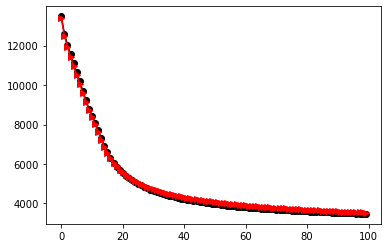

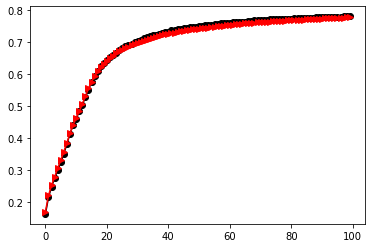

In [15]:
# 画出准确率与损失图像，并保存为文件
lower = 0
plt.plot(test_loss_list[lower:], color='black', label='test loss', marker='o')
plt.plot(train_loss_list[lower:], color='red', label='train loss', marker='>')
plt.show()

plt.plot(test_accu_list[lower:], color='black', label='test accuracy', marker='o')
plt.plot(train_accu_list[lower:], color='red', label='train accuracy', marker='>')
plt.show()

In [16]:
parameters[1]["w"]

array([[-0.67270237,  0.9810712 , -0.11475327, ..., -0.39853643,
        -0.08838707, -0.68771297],
       [ 0.84058448,  0.48623412, -0.56714453, ..., -0.67267261,
        -0.43517648, -0.33376952],
       [-0.61327188, -0.13250339, -0.89887732, ...,  0.39713165,
        -0.79179827, -0.54194629],
       ...,
       [ 0.93048624, -0.42971492,  0.20652627, ..., -0.68981148,
        -0.74103511,  0.73012521],
       [ 0.33034236, -0.07508209, -0.68800569, ..., -0.58433446,
         0.95717053,  0.88344327],
       [ 0.86471248,  0.62236509, -0.84690544, ...,  0.99748539,
        -0.72694894, -0.22280014]])

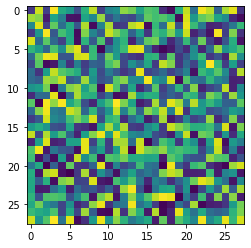

In [20]:
w = parameters[1]["w"].copy()
plt.imshow(w[:,0].reshape((28,28)))
np.save("w0_origin.npy", w[:,0])

In [21]:
accu = train_accu_list.copy()
np.savetxt("origin train accu.txt", accu)